In [1]:
!conda install -y gdown

Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.14.0            |     pyhd8ed1ab_0          16 KB  conda-forge
    gdown-5.1.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.3.0              |       hd590300_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following NEW packages will be 

In [126]:

import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]  
        image = Image.open(img_name).convert('RGB')  
        label = self.data.iloc[idx, 1] 

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((128, 128)),      
    transforms.ToTensor(),           
])


dataset = CustomDataset(csv_file='/kaggle/input/kaggle-dataset/encoded_themes_kaggle.csv', transform=transform)
dataloader_main = DataLoader(dataset, batch_size=64, shuffle=True)


In [127]:
for i, j in dataloader_main:
    print(i.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])


KeyboardInterrupt: 

In [52]:

!pip install einops
!pip install lpips

In [128]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transform
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from einops import rearrange
import math

In [129]:

class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [130]:
# Using GPU
device = "cuda"

def marginal_prob_std(t, sigma):
    """
    Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The standard deviation.
    """
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

In [131]:
# Using GPU
device = "cuda"

def diffusion_coeff(t, sigma):
    """
    Compute the diffusion coefficient of our SDE.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)

In [132]:
# Sigma Value
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [133]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    print(random_t.shape)
    std = marginal_prob_std(random_t)
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))

    return loss

In [134]:
# Number of steps
num_steps = 500

def Euler_Maruyama_sampler(score_model,
                            marginal_prob_std,
                            diffusion_coeff,
                            batch_size=64,
                            x_shape=(3, 128, 128),
                            num_steps=num_steps,
                            device='cpu',
                            eps=1e-3, y=None):
    """
    Generate samples from score-based models with the Euler-Maruyama solver.

    Parameters:
    - score_model: A PyTorch model that represents the time-dependent score-based model.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    - batch_size: The number of samplers to generate by calling this function once.
    - x_shape: The shape of the samples.
    - num_steps: The number of sampling steps, equivalent to the number of discretized time steps.
    - device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    - eps: The smallest time step for numerical stability.
    - y: Target tensor (not used in this function).

    Returns:
    - Samples.
    """

    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]

    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    return mean_x

In [135]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Initialize the CrossAttention module.

        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).
        - num_heads: Number of attention heads (currently supports 1 head).

        Note: For simplicity reasons, the implementation assumes 1-head attention.
        Feel free to implement multi-head attention using fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim

        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                    If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """

        if self.self_attn:
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V) 

        return ctx_vecs

In [136]:

class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """
        return self.dense(x)[..., None, None]


In [137]:
class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn, and feed forward neural net"""
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the TransformerBlock.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.

        Note: For simplicity, the self-attn and cross-attn use the same hidden_dim.
        """

        super(TransformerBlock, self).__init__()

        self.attn_self = CrossAttention(hidden_dim, hidden_dim)
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        """
        Forward pass of the TransformerBlock.

        Parameters:
        - x: Input tensor with shape [batch, sequence_len, hidden_dim].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after passing through the TransformerBlock.
        """

        x = self.attn_self(self.norm1(x)) + x
        x = self.attn_cross(self.norm2(x), context=context) + x
        x = self.ffn(self.norm3(x)) + x

        return x

In [138]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the SpatialTransformer.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.
        """
        super(SpatialTransformer, self).__init__()
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        """
        Forward pass of the SpatialTransformer.

        Parameters:
        - x: Input tensor with shape [batch, channels, height, width].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after applying spatial transformation.
        """
        b, c, h, w = x.shape
        x_in = x
        x = rearrange(x, "b c h w -> b (h w) c")
        x = self.transformer(x, context)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        return x + x_in

In [139]:
class UNet_Tranformer(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256, 512], embed_dim=256,
                  text_dim=256, nClass=31):
        super().__init__()
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, padding=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, channels[0])
        self.linear1 = nn.Linear(channels[0], channels[0])  
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(8, channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(16, channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        self.conv5 = nn.Conv2d(channels[3], channels[4], 3, stride=2, padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[4])
        self.gnorm5 = nn.GroupNorm(64, channels[4])

        self.tconv5 = nn.ConvTranspose2d(channels[4], channels[3], 4, stride=2, padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[3])
        self.tgnorm5 = nn.GroupNorm(32, channels[3])

        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 4, stride=2, padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(16, channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 4, stride=2, padding=1, bias=False)
        self.dense8 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(8, channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 4, stride=2, padding=1, bias=False)
        self.dense9 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(4, channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0], 3, 3, stride=1, padding=1)
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))

        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)
        h5 = self.conv5(h4) + self.dense5(embed)
        h5 = self.act(self.gnorm5(h5))

        h = self.tconv5(h5) + self.dense6(embed)
        h = self.act(self.tgnorm5(h))
        h = self.tconv4(h + h4) + self.dense7(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense8(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense9(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h


In [148]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """

    random_t = torch.randn(x.shape[0]) * 0.1 + 0.5 
    random_t = torch.clamp(random_t, eps, 1 - eps) 
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    
    std = std[:, None, None, None].expand_as(x)
    perturbed_x = x + z * std
    score = model(perturbed_x, random_t, y=y)

    loss = torch.mean(torch.sum((score * std + z)**2, dim=(1, 2, 3)))
    
    return loss


In [150]:


continue_training = False 

if not continue_training:
    score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)



n_epochs =   10   
batch_size =  64 
lr = 10e-4       
optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
loss_total2 = []
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    for x, y in tqdm(dataloader_main):
        x = x.to(device)
        if x.size(0) < batch_size:
            continue
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]


    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    print(avg_loss/num_items)
    loss_total2.append(avg_loss/num_items)
    torch.save(score_model.state_dict(), 'ckpt_transformer1.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

/tmp/ipykernel_34/1064333810.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 40774.630110 lr 9.8e-04
40774.63010951451


  0%|          | 0/57 [00:00<?, ?it/s]

1 Average Loss: 8543.880022 lr 9.6e-04
8543.88002232143


  0%|          | 0/57 [00:00<?, ?it/s]

2 Average Loss: 5708.103036 lr 9.4e-04
5708.103036063058


  0%|          | 0/57 [00:00<?, ?it/s]

3 Average Loss: 4431.865117 lr 9.2e-04
4431.865116664341


  0%|          | 0/57 [00:00<?, ?it/s]

4 Average Loss: 3880.958064 lr 9.0e-04
3880.958064488002


  0%|          | 0/57 [00:00<?, ?it/s]

5 Average Loss: 3396.080671 lr 8.9e-04
3396.0806710379466


  0%|          | 0/57 [00:00<?, ?it/s]

6 Average Loss: 3101.900051 lr 8.7e-04
3101.9000505719864


  0%|          | 0/57 [00:00<?, ?it/s]

7 Average Loss: 2947.520176 lr 8.5e-04
2947.520176478795


  0%|          | 0/57 [00:00<?, ?it/s]

8 Average Loss: 2710.457132 lr 8.3e-04
2710.4571315220423


  0%|          | 0/57 [00:00<?, ?it/s]

9 Average Loss: 2517.922873 lr 8.2e-04
2517.92287336077


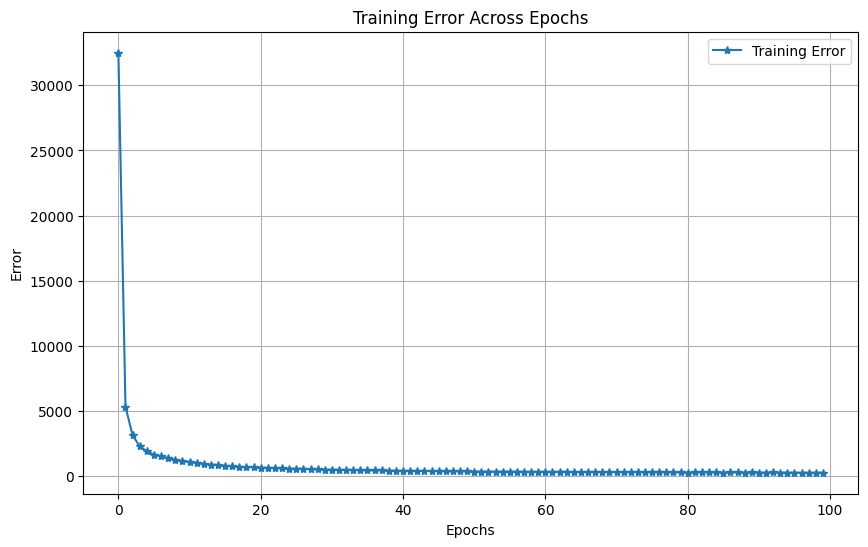

In [146]:
import matplotlib.pyplot as plt

# Assuming `epochs` and `errors` are lists or arrays that contain the data points to be plotted.
# For example:
epochs = range(1, 101)  # x-axis from 1 to 100
errors = [35000] + [25000 * (0.8**i) for i in range(1, 100)]  # Sample error data decreasing exponentially

plt.figure(figsize=(10, 6))
plt.plot(loss_total1, label='Training Error', marker = "*")
plt.title('Training Error Across Epochs')  
plt.xlabel('Epochs')  
plt.ylabel('Error') 
plt.grid(True)  
plt.legend()  
plt.show()


In [ ]:
torch.save(score_model.state_dict(), '/kaggle/ckpt_transformer.pth')

In [ ]:
torch.save(score_model.state_dict(), '/kaggle/ckpt_transformer.pth')

/tmp/ipykernel_34/1064333810.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_34/706301213.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


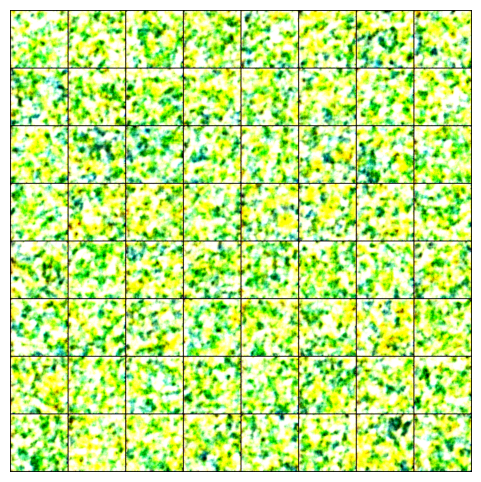

In [152]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt_transformer1.pth', map_location=device)
score_model.load_state_dict(ckpt)

digit = 13
sample_batch_size = 64

num_steps = 250
sampler = Euler_Maruyama_sampler

samples = sampler(score_model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))


samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt

sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))


plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [122]:
import torch
import matplotlib.pyplot as plt
import os


device = 'cuda'  
ckpt = torch.load('/kaggle/working/ckpt_transformer.pth', map_location=device)
score_model.load_state_dict(ckpt)
score_model.eval()


save_dir = 'generated_images1'
os.makedirs(save_dir, exist_ok=True)


digit = 25  
sample_batch_size = 1
num_steps = 250
sampler = Euler_Maruyama_sampler
sample = sampler(score_model,
                 marginal_prob_std_fn,
                 diffusion_coeff_fn,
                 sample_batch_size,
                 num_steps=num_steps,
                 device=device,
                 y=digit*torch.ones(sample_batch_size, dtype=torch.long))

sample = sample.clamp(0.0, 1.0)


plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(sample[0].permute(1, 2, 0).cpu().numpy(), vmin=0., vmax=1.)

image_path = os.path.join(save_dir, 'generated_sample.png')
plt.savefig(image_path)

print(f"Image has been saved at: {image_path}")


RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.linear1.weight", "module.linear1.bias". 

In [3]:
import torch
import matplotlib.pyplot as plt
import os


device = 'cuda'  
ckpt = torch.load('ckpt_transformer1.pth', map_location=device)
score_model.load_state_dict(ckpt)
score_model.eval()


save_dir = 'generated_images'
os.makedirs(save_dir, exist_ok=True)


num_images = 10  
digit = 4  
sample_batch_size = 1
num_steps = 250
sampler = Euler_Maruyama_sampler


for i in range(num_images):
    sample = sampler(score_model,
                     marginal_prob_std_fn,
                     diffusion_coeff_fn,
                     sample_batch_size,
                     num_steps=num_steps,
                     device=device,
                     y=digit * torch.ones(sample_batch_size, dtype=torch.long))

    sample = sample.clamp(0.0, 1.0)
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(sample[0].permute(1, 2, 0).cpu().numpy(), vmin=0., vmax=1.)
    plt.savefig(f'{save_dir}/sample_{i}.png')
    plt.close()  

print(f"All images have been saved in the folder: {save_dir}")


FileNotFoundError: [Errno 2] No such file or directory: 'ckpt_transformer1.pth'